In [33]:
import requests
import folium
import urllib
from pandas.io.json import json_normalize
import pandas as pd
import folium
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer
import os
import pdal
from osgeo import gdal
import json
from ipywidgets import interact
from ipywidgets import widgets
import imageio
import pathlib
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
import laspy
import rasterio
from rasterio import mask
from glob import glob
from shapely.geometry import box
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [22]:
def read_text(text_path):
    text = []
    with open(text_path) as fp:
        line = fp.readline()
        while line:
            line = line.rstrip("\n")
            text.append(line)
            line = fp.readline()
    return text

In [42]:
class Lidar():
    def __init__(self):
        self.text_path = 'filename.txt'
        self.PUBLIC_DATA = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"
        self.output_file = 'spatial_subset.geojson'
        
    def region(self):
        self.output_slider_variable = widgets.Text()
                
        # Define function to bind value of the input to the output variable 
        def f(x):
            self.output_slider_variable.value = str(x)

        dropdown = interact(f, x=read_text(self.text_path))
        return self.output_slider_variable

    def ept_json(self):
        self.new_variable = str(self.output_slider_variable.value)
        self.PUBLIC_ACCESS_PATH = self.PUBLIC_DATA + self.new_variable + "ept.json"
        return self.PUBLIC_ACCESS_PATH
    
    def pipeline(self, xmin, xmax, ymin, ymax):
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        xmin, ymax = transformer.transform(xmin, ymax)
        xmax, ymin = transformer.transform(xmax, ymin)
        self.pdal_aoi_bounds = f"([{xmin}, {xmax}], [{ymin}, {ymax}])"
        return self.pdal_aoi_bounds
        
    ## Define a function for running a pdal pipeline and returning the filename as output
    def run_pipeline(self):
        pipeline_def =  [
        {
            "bounds": self.pdal_aoi_bounds,
            "filename": self.PUBLIC_ACCESS_PATH,
            "type": "readers.ept",
            "tag": "readdata"
        },
        {
            "limits": "Classification![2:7], Classification![9:9]",
            "type": "filters.range",
            "tag": "nonoise"
        },
        {
            "filename": "spatial_subset.laz",
            "inputs": [ "nonoise" ],
            "tag": "writerslas",
            "type": "writers.las"
        },
       {
            "filename": "spatial_subset.tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "inputs": [ "writerslas" ],
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
        },
        {
        "type" : "writers.text",
        "format": "geojson",
        "write_header": True
        }
    ]
    
        output_file = self.output_file
        pipeline_def[-1]["filename"] = output_file
        pipeline_json =  json.dumps(pipeline_def)
        pipeline = pdal.Pipeline(pipeline_json)

        # remove the output file before building a new one
        if os.path.exists(output_file):
            os.remove(output_file)

        count = pipeline.execute()
        data = open(output_file, 'r').read()
        data = data.replace("[,{", "[{").replace("}{", "},{")
        open(output_file, 'w').write(data)
        return output_file
    
    def geodf(self, geojsonfile):
        df = gpd.read_file(geojsonfile)
        geometry = [Point(xy) for xy in zip(pd.to_numeric(df['X']), pd.to_numeric(df['Y']))]
        gdf = gpd.GeoDataFrame(df, crs='epsg:4326',geometry=geometry)
        gdf = gdf[["Z", "geometry"]]
        gdf = gdf.rename(columns={"Z": "elevation_m", "geometry": "geometry"})
        return gdf
    
    def plot_raster(self, rasterfile):
        dataset = gdal.Open(rasterfile)
        band1 = dataset.GetRasterBand(1)
        self.b1 = band1.ReadAsArray()
        img = self.b1
        f = plt.figure()
        plt.imshow(img)
        cbar = plt.colorbar()
        plt.savefig('Tiff.png')
        plt.show()
        
    def plot3d(self):
        #create meshgrid
        X, Y = np.meshgrid(np.linspace(0, 2, 982), np.linspace(0, 2, len(self.b1)))
        # Plot surface
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, self.b1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
        ax.set_title('surface');
        
        
    

In [43]:
m=Lidar()

In [44]:
m.region()

interactive(children=(Dropdown(description='x', options=('AK_BrooksCamp_2012/', 'AK_Coastal_2009/', 'AK_Fairba…

Text(value='AK_BrooksCamp_2012/')

In [45]:
m.ept_json()

'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json'

In [46]:
m.pipeline(xmin = -93.756155,xmax = -93.747334, ymin = 41.918015, ymax = 41.921429)

'([-10436887.43333523, -10435905.484106943], [5148706.389047224, 5149217.145836504])'

In [47]:
m.run_pipeline()

'spatial_subset.geojson'

In [48]:
m.geodf('spatial_subset.geojson')

,elevation_m,geometry
0,318.490,POINT (-10435906.070 5149216.030)
1,318.370,POINT (-10435907.330 5149215.640)
2,318.410,POINT (-10435908.700 5149215.960)
3,318.150,POINT (-10435921.570 5149216.780)
4,318.290,POINT (-10435920.250 5149216.480)
...,...,...
403326,318.040,POINT (-10435991.800 5149213.980)
403327,318.100,POINT (-10435968.960 5149217.050)
403328,317.770,POINT (-10436002.880 5149215.030)
403329,317.880,POINT (-10436005.220 5149214.710)


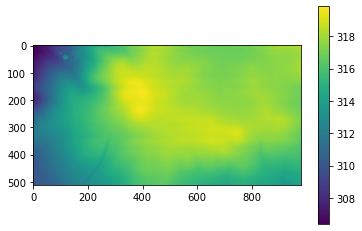

In [49]:
m.plot_raster('spatial_subset.tif')

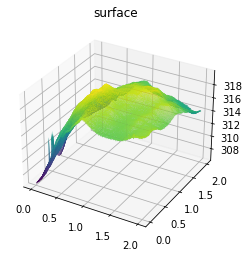

In [50]:
m.plot3d()

In [66]:
def get_shp_from_tif(tif_path:str, shp_file_path:str) -> None:
    raster = rasterio.open(tif_path)
    bounds = raster.bounds

    df = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]})
   
    # save to file
    df.to_file(shp_file_path)
    print('Saved..')

In [67]:
get_shp_from_tif('spatial_subset.tif', shp_file_path='spatial_subset.shp')

Saved..


In [60]:
#extract polygon from shapefile
pts = gpd.GeoDataFrame.from_file('spatial_subset.shp')

In [62]:
pd.set_option('display.max_colwidth', None)
pts

,id,geometry
0,1,"POLYGON ((-10435905.430 5148706.390, -10436887.430 5148706.390, -10436887.430 5149217.390, -10435905.430 5149217.390, -10435905.430 5148706.390))"


In [63]:
pts.shape

(1, 2)

In [64]:
pts.bounds

,minx,miny,maxx,maxy
0,-10436887.43,5148706.39,-10435905.43,5149217.39


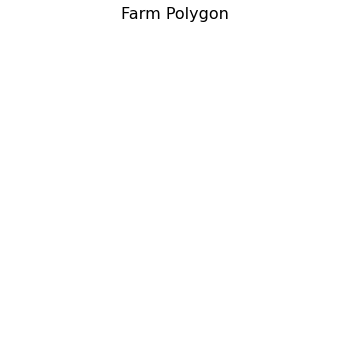

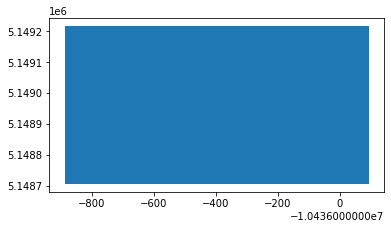

In [65]:
# plot the data
fig, ax = plt.subplots(figsize = (6, 6))
pts.plot(aspect=1)
ax.set_title("Farm Polygon", 
             fontsize = 16)
ax.set_axis_off();